# Stochastic Trajectory Prediction using LSTMs

### Quick demo of using the LSTM model

This Notebook aims to show how we can utilise the implemented model in this repository.

### Initialisation

We begin by importing everything necessary including all datasets we will use for training, followed by assigning all constant variables we will need for training the network.



In [1]:
import os
import time

import numpy as np
import tensorflow as tf

import utils.data_tools as data_tools
import utils.visualisation as visualisation
import utils.distributions as distributions

from models.lstm import BasicLSTM
from models.lstm import reset_graph

training_directories = ['../data/eth/univ',
                 '../data/ucy/zara/zara01',
                 '../data/ucy/zara/zara02']

BATCH_SIZE = 50
NUM_EPOCHS = 100
DECAY_RATE = 0.95
SEQUENCE_LENGTH = 8
SAVE_PATH = "../save"

avg_time = 0
avg_loss = 0

/Users/alice/anaconda/envs/mlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Preparing the data and model
Before training, we need to preprocess and load our data. It is always good practice to reset the graph on Tensorflow in order to avoid interference with ran in parallel instances of the same graph.

In [2]:
agentsData, dicto, dataset_indices = data_tools.preprocess(training_directories)
loaded_data, num_batches = data_tools.load_preprocessed(agentsData, BATCH_SIZE, SEQUENCE_LENGTH)

reset_graph()
lstm = BasicLSTM()

graph successfully reset


## Training

In order to train the network, we will begin by initialising a session, and then for as long as there are batches left, we will take a new one and run our model, at each such step the model updates its parameters. We repeat this process for a chosen in advance number of epochs.

Although not necessary, we can dedect the time it takes us to process a single batch. We will print the average result over 100 steps.

In [3]:
for e in range(NUM_EPOCHS):
    # Assign the learning rate (decayed acc. to the epoch number)
    lstm.sess.run(tf.assign(lstm.lr, lstm.learning_rate * (DECAY_RATE ** e)))
    # Reset the pointers in the data loader object
    pointer = data_tools.reset_batch_pointer()
    # Get the initial cell state of the LSTM
    state = lstm.sess.run(lstm.initial_state)
    
    # For each batch in this epoch
    for b in range(num_batches):
        start = time.time()
        # Get the source and target data of the current batch
        # x has the source data, y has the target data
        x, y, pointer = data_tools.next_batch(
            loaded_data, pointer, BATCH_SIZE, SEQUENCE_LENGTH)
        x = np.array(x)
        y = np.array(y)

        # Feed the source, target data and the initial LSTM state to the model
        feed = {
            lstm.input_data: x[:, :, 1:],
            lstm.target_data: y[:, :, 1:],
            lstm.initial_state: state
        }
        # Fetch the loss of the model on this batch,
        # the final LSTM state from the session
        train_loss, state, _ = lstm.sess.run(
            [lstm.cost, lstm.final_state, lstm.train_op], feed)
        # Toc
        end = time.time()

        cur_time = end - start
        step = e * num_batches + b
        
        avg_time += cur_time
        avg_loss += train_loss
        
        # Print epoch, batch, loss and time taken
        if (step%99) == 0:
            print(
                "{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"
                .format(
                    step,
                    NUM_EPOCHS * num_batches,
                    e,
                    avg_loss/99.0, avg_time/99.0))
            
            avg_time = 0
            avg_loss = 0

os.makedirs(SAVE_PATH, exist_ok=True)
# Save parameters after the network is trained
lstm.save_json(os.path.join(SAVE_PATH, "params.json"))

0/3300 (epoch 0), train_loss = 0.111, time/batch = 0.001
99/3300 (epoch 3), train_loss = 8.381, time/batch = 0.011
198/3300 (epoch 6), train_loss = 0.682, time/batch = 0.011
297/3300 (epoch 9), train_loss = -0.526, time/batch = 0.011
396/3300 (epoch 12), train_loss = -0.861, time/batch = 0.012
495/3300 (epoch 15), train_loss = -1.372, time/batch = 0.012
594/3300 (epoch 18), train_loss = -1.708, time/batch = 0.011
693/3300 (epoch 21), train_loss = -1.427, time/batch = 0.012
792/3300 (epoch 24), train_loss = -2.013, time/batch = 0.012
891/3300 (epoch 27), train_loss = -2.363, time/batch = 0.011
990/3300 (epoch 30), train_loss = -2.439, time/batch = 0.011
1089/3300 (epoch 33), train_loss = -2.742, time/batch = 0.011
1188/3300 (epoch 36), train_loss = -3.005, time/batch = 0.012
1287/3300 (epoch 39), train_loss = -3.069, time/batch = 0.011
1386/3300 (epoch 42), train_loss = -3.186, time/batch = 0.012
1485/3300 (epoch 45), train_loss = -3.289, time/batch = 0.011
1584/3300 (epoch 48), train_l

## Test

In order to test we are no longer interested in obtaining entire batches but we need to consider single entries.
Moreover, we need to first observe part of the trajectory in order to make a prediction. Thus, we redefine some of the variables from above as follows.

We then take the test dataset, preprocess it and load it in a relevant format.

In [4]:
BATCH_SIZE = 1
OBSERVED_LENGTH = 4
PREDICTED_LENGTH = 4
SEQUENCE_LENGTH = OBSERVED_LENGTH + PREDICTED_LENGTH

test_directory = "../data/seq_hotel"
agentsData, statistics, peds_in_frame = data_tools.mil_to_pixels(test_directory)
data, num_batches = data_tools.load_preprocessed(agentsData, BATCH_SIZE, SEQUENCE_LENGTH)

We define a model with a sequence length of 1 since we will be predicting for each step individually.

In [5]:
reset_graph()
lstm = BasicLSTM(batch_size=1, sequence_length=1)
lstm.load_json(os.path.join(SAVE_PATH, "params.json"))

state = lstm.sess.run(lstm.initial_state)
pointer = data_tools.reset_batch_pointer()

xs = []
ys = []
total_error = 0

graph successfully reset


### Inference

For a given trajectory, the idea is to simply update the cell state at each step using the final cell state value from our previous prediction.

We then measure the performance of the network through the average displacement error.

In [6]:
for b in range(num_batches):
    start = time.time()
    # Get the source and target data of the current batch
    # x has the source data, y has the target data
    x, y, pointer = data_tools.next_batch(data, pointer, BATCH_SIZE, SEQUENCE_LENGTH)
    x = np.array(x)
    y = np.array(y)

    obs_traj = x[0,:OBSERVED_LENGTH, 1:]
    for position in obs_traj[:-1]:
        # Create the input data tensor
        input_data_tensor = np.zeros((1, 1, 2), dtype=np.float32)
        input_data_tensor[0, 0, 0] = position[0]  # x
        input_data_tensor[0, 0, 1] = position[1]  # y

        # Create the feed dict
        feed = {lstm.input_data: input_data_tensor, lstm.initial_state: state}
        # Get the final state after processing the current position
        [state] = lstm.sess.run([lstm.final_state], feed)

    returned_traj = obs_traj
    last_position = obs_traj[-1]

    prev_data = np.zeros((1, 1, 2), dtype=np.float32)
    prev_data[0, 0, 0] = last_position[0]  # x
    prev_data[0, 0, 1] = last_position[1]  # y

    prev_target_data = np.reshape(x[0][obs_traj.shape[0], 1:], (1, 1, 2))
    for t in range(PREDICTED_LENGTH):
        feed = {
            lstm.input_data: prev_data,
            lstm.initial_state: state,
            lstm.target_data: prev_target_data}
        [o_mux, o_muy, o_sx, o_sy, o_corr, state, cost] = lstm.sess.run(
            [lstm.mux, lstm.muy, lstm.sx, lstm.sy, lstm.corr, lstm.final_state, lstm.cost], feed)


        next_x, next_y = distributions.sample_2d_normal(o_mux, o_muy, o_sx, o_sy, o_corr)
        returned_traj = np.vstack((returned_traj, [next_x, next_y]))

        prev_data[0, 0, 0] = next_x
        prev_data[0, 0, 1] = next_y

    complete_traj = returned_traj

    total_error += distributions.get_mean_error(complete_traj, x[0, :, 1:], OBSERVED_LENGTH)
    if (b+1) % 50 == 0:
        print("Processed trajectory number : ", b+1, "out of ", num_batches, " trajectories")

print("Total mean error of the model is ", total_error/num_batches)

Processed trajectory number :  50 out of  461  trajectories
Processed trajectory number :  100 out of  461  trajectories
Processed trajectory number :  150 out of  461  trajectories
Processed trajectory number :  200 out of  461  trajectories
Processed trajectory number :  250 out of  461  trajectories
Processed trajectory number :  300 out of  461  trajectories
Processed trajectory number :  350 out of  461  trajectories
Processed trajectory number :  400 out of  461  trajectories
Processed trajectory number :  450 out of  461  trajectories
Total mean error of the model is  0.09634385035396954


### Visualisation

Load the video and plot a trajectory on the chosen frame.
Use 'q' to close the window.

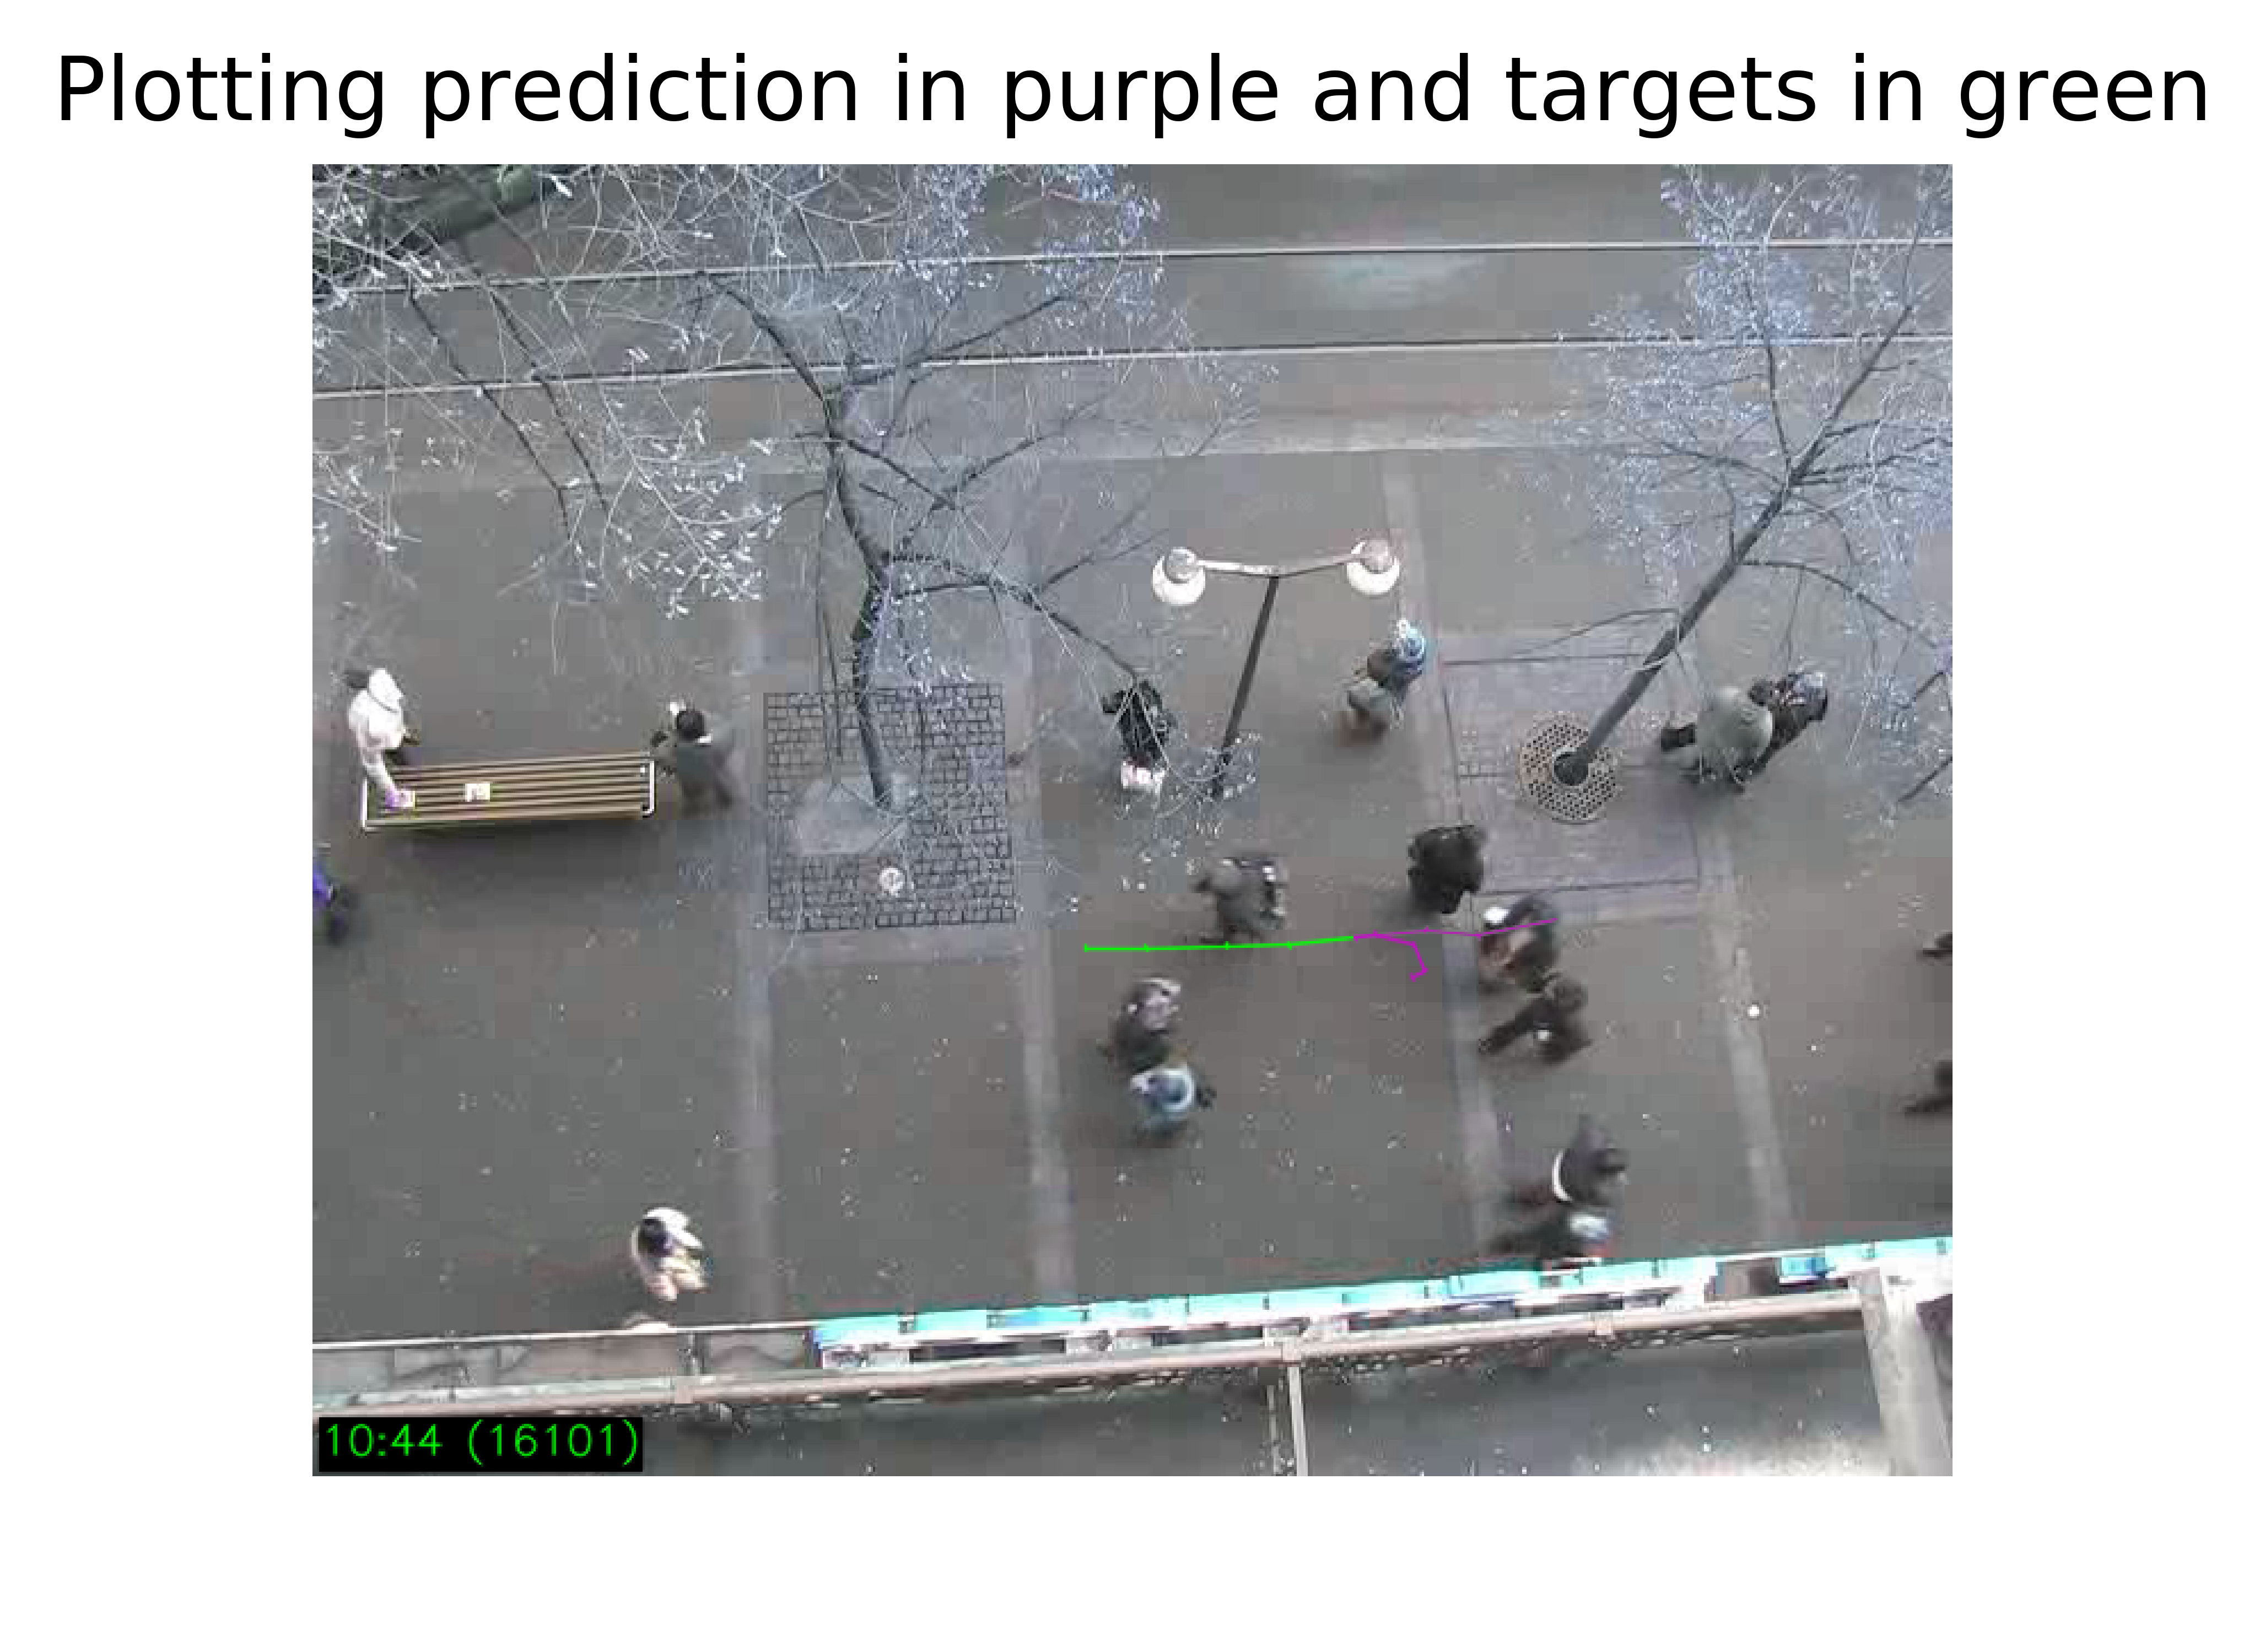

In [7]:
seqname = "seq_hotel"
videopath = os.path.join("../data/seq_hotel", seqname+".avi")

visualisation.plot(x, complete_traj, statistics, x[0][0][0], videopath)